In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import pygame
import matplotlib.pyplot as plt

# Define your PongEnvironment class
class PongEnvironment:
    ACTION_SPACE = [0, 1]  # Define the action space

    def __init__(self, width=400, height=300):
        self.width = width
        self.height = height
        self.ball_radius = 10
        self.paddle_width = 10
        self.paddle_height = 60
        self.paddle_offset = 20
        self.clock = pygame.time.Clock()
        self.screen = pygame.display.set_mode((self.width, self.height))
        pygame.display.set_caption("Pong")
        self.reset()

    def step(self, action):
        self.move_paddle(action)
        self.ball_pos += self.ball_vel

        reward = 0  # Initialize reward to 0
        done = False  # Initialize done to False

        if self.ball_pos[1] <= self.ball_radius or self.ball_pos[1] >= self.height - self.ball_radius:
            self.ball_vel[1] *= -1

        if self.ball_pos[0] <= self.ball_radius:
            reward = 0  # Reward is 0 for missing the ball
            done = True
        elif self.ball_pos[0] >= self.width - self.ball_radius:
            if self.paddle_pos - self.paddle_height / 2 <= self.ball_pos[1] <= self.paddle_pos + self.paddle_height / 2:
                reward = 1  # Reward is 1 for hitting the ball
                self.ball_vel[0] *= -1
            else:
                reward = 0  #zero
                done = True

    # Check if the episode should be truncated
        if self.time_since_last_hit > 10000:  # 10 seconds in milliseconds
            done = True

        return self.get_state(), reward, done

    def reset(self):
        self.ball_pos = np.array([self.width // 2, random.randint(0, self.height)], dtype=float)
        self.ball_vel = np.array([random.uniform(0.03, 0.05), random.uniform(0.01, 0.03)], dtype=float)
        self.paddle_pos = self.height // 2
        self.time_since_last_hit = 0  # Reset timer
        return self.get_state()

    def move_paddle(self, action):
        paddle_speed = 5  # Adjust the speed of the paddle's movement as needed
        self.paddle_pos = np.clip(self.paddle_pos + action * paddle_speed, self.paddle_height / 2, self.height - self.paddle_height / 2)

    def get_state(self):
        return np.array([
            self.ball_pos[0] / self.width,
            self.ball_pos[1] / self.height,
            self.ball_vel[0],
            self.ball_vel[1],
            self.paddle_pos / self.height
        ], dtype=np.float32)  # Ensure consistent data type

    def render(self):
        self.screen.fill((0, 0, 0))
        pygame.draw.rect(self.screen, (255, 255, 255), pygame.Rect(0, self.paddle_pos - self.paddle_height / 2, self.paddle_width, self.paddle_height))
        pygame.draw.circle(self.screen, (255, 255, 255), (int(self.ball_pos[0]), int(self.ball_pos[1])), self.ball_radius)
        pygame.display.flip()

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


Episode 1/100, Total Reward: 1, Loss: 0.11587171256542206
Episode 2/100, Total Reward: 0, Loss: 0.035449691116809845
Episode 3/100, Total Reward: 0, Loss: 0.010139791294932365
Episode 4/100, Total Reward: 0, Loss: 0.0006470363005064428
Episode 5/100, Total Reward: 0, Loss: 0.014401399530470371
Episode 6/100, Total Reward: 0, Loss: 0.014954283833503723
Episode 7/100, Total Reward: 1, Loss: 0.11316850036382675
Episode 8/100, Total Reward: 1, Loss: 0.11177945882081985
Episode 9/100, Total Reward: 0, Loss: 0.0018581484910100698
Episode 10/100, Total Reward: 0, Loss: 0.006708732806146145
Episode 11/100, Total Reward: 0, Loss: 0.011552905663847923
Episode 12/100, Total Reward: 0, Loss: 0.006829218473285437
Episode 13/100, Total Reward: 0, Loss: 0.003367022844031453
Episode 14/100, Total Reward: 0, Loss: 0.0005662491894327104
Episode 15/100, Total Reward: 0, Loss: 0.0020612331572920084
Episode 16/100, Total Reward: 0, Loss: 0.00521064130589366
Episode 17/100, Total Reward: 1, Loss: 0.11246041

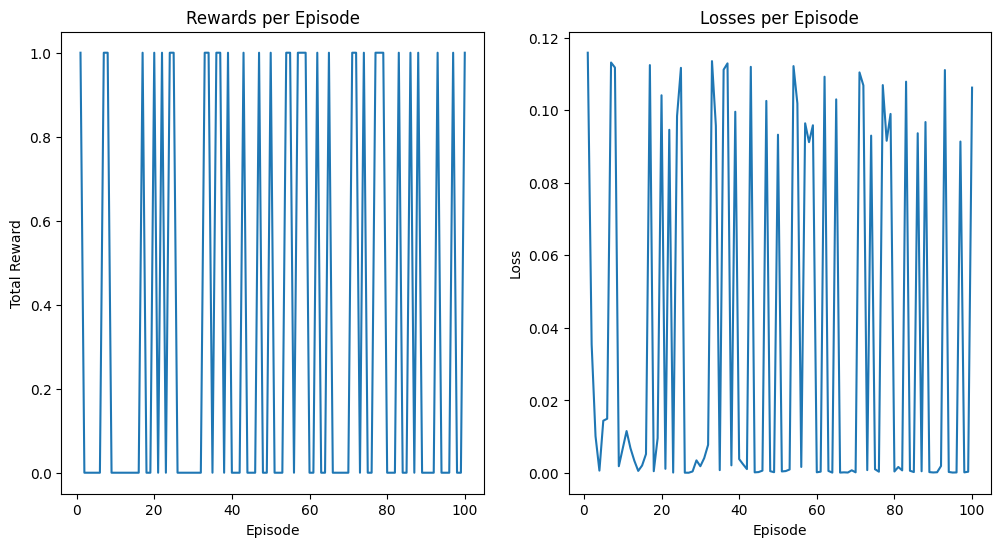

In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt

# Define ActorCritic class
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(ActorCritic, self).__init__()

        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        value = self.critic(x)
        probs = self.actor(x)
        dist  = Categorical(probs)
        return dist, value

# Define A2C agent class
class A2CAgent:
    def __init__(self, env, lr=0.01, gamma=0.99):
        self.env = env
        self.lr = lr
        self.gamma = gamma
        self.actor_critic = ActorCritic(env.get_state().shape[0], len(env.ACTION_SPACE), 128)
        self.optimizer = optim.Adam(self.actor_critic.parameters(), lr=lr)

    def train(self, num_episodes):
        all_rewards = []
        all_losses = []
        for episode in range(num_episodes):
            state = self.env.reset()
            done = False
            rewards = []
            log_probs = []
            values = []
            while not done:
                state = torch.FloatTensor(state).unsqueeze(0)
                dist, value = self.actor_critic(state)
                action = dist.sample()
                next_state, reward, done = self.env.step(action.item())
                rewards.append(reward)
                log_probs.append(dist.log_prob(action))
                values.append(value)
                state = next_state

            all_rewards.append(sum(rewards))

            # Compute returns
            returns = []
            R = 0
            for r in reversed(rewards):
                R = r + self.gamma * R
                returns.insert(0, R)
            returns = torch.tensor(returns)
            returns = (returns - returns.mean()) / (returns.std() + 1e-5)

            # Compute actor and critic losses
            actor_loss = -(torch.stack(log_probs) * returns.detach()).mean()  # Policy gradient
            critic_loss = nn.functional.smooth_l1_loss(torch.cat(values), returns.unsqueeze(1))

            # Compute total loss
            loss = actor_loss + critic_loss

            # Update actor critic
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            all_losses.append(loss.item())

            print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {sum(rewards)}, Loss: {loss.item()}")

        return all_rewards, all_losses


# Create PongEnvironment instance
env = PongEnvironment()

# Create A2C agent
agent = A2CAgent(env)

# Train the agent
num_episodes = 100
rewards, losses = agent.train(num_episodes)

# Plot rewards and losses per episode
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_episodes + 1), rewards)
plt.title('Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_episodes + 1), losses)
plt.title('Losses per Episode')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.show()
